## Plot a single function 

In [2]:
import math, sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.typing import NDArray
import time
from typing import Callable
from Project1 import *

np.random.seed(123)

plt.rcParams.update({
    "figure.figsize": (6,5),
    "axes.grid": False
})

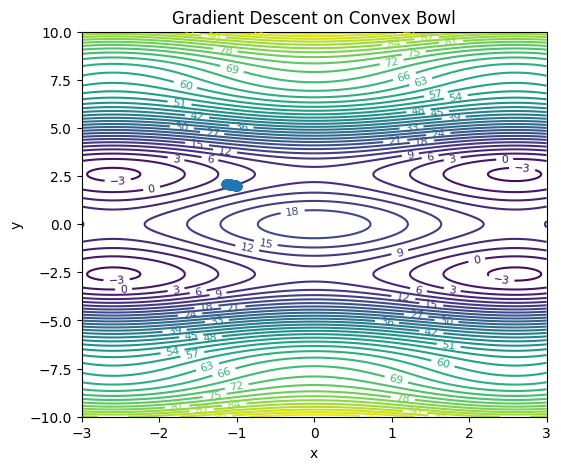

In [3]:
class ConvexBowl(C2Differentiable):
    """Convex bowl function."""
    def forward(self, x):
        return x[0]**2 + x[1]**2
    def derivative(self, x):
        return np.array([2*x[0], 2*x[1]])
    def second_derivative(self, x):
        return np.array([[2, 0], [0, 2]])


class Rosenbrock(C2Differentiable):
    """Rosenbrock (banana valley) function.
    f(x,y) = (1-x)² + 100(y-x²)²
    """
    def forward(self, x):
        return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2
    
    def derivative(self, x):
        df_dx = -2 * (1 - x[0]) - 400 * x[0] * (x[1] - x[0]**2)
        df_dy = 200 * (x[1] - x[0]**2)
        return np.array([df_dx, df_dy])
    
    #! NOT SURE IF THIS IS CORRECT SECOND DERIVATIVE
    def second_derivative(self, x):
        d2f_dx2 = 2 - 400 * x[1] + 1200 * x[0]**2
        d2f_dy2 = 200
        d2f_dxdy = -400 * x[0]
        
        return np.array([[d2f_dx2, d2f_dxdy], 
                        [d2f_dxdy, d2f_dy2]])

class CosineBumps(C2Differentiable):
    """Multimodal cosine bumps.
    f(x,y) = x² + y² + 10cos(x) + 10cos(y)
    """
    def forward(self, x):
        return x[0]**2 + x[1]**2 + 10*np.cos(x[0]) + 10*np.cos(x[1])
    
    def derivative(self, x):
        df_dx = 2*x[0] - 10*np.sin(x[0])
        df_dy = 2*x[1] - 10*np.sin(x[1])
        return np.array([df_dx, df_dy])
    
    def second_derivative(self, x):
        d2f_dx2 = 2 - 10*np.cos(x[0])
        d2f_dy2 = 2 - 10*np.cos(x[1])
        d2f_dxdy = 0 
        
        return np.array([[d2f_dx2, d2f_dxdy], 
                        [d2f_dxdy, d2f_dy2]])



class GradientDescent:

    def __init__(self, f: C1Differentiable, x0, alpha=0.00001, tol=1e-6, max_iter=2000):
        super().__init__()

        self.f = f
        self.x = x0
        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter

    def optimize(self):
        self.f.clear_history()
        
        for _ in range(self.max_iter):
            grad = self.f.derivative(self.x)
            y = self.f.forward(self.x)

            new_x = self.x - self.alpha * grad
            self.f.add_history([self.x[0], self.x[1], y])
            
            if abs(self.f.forward(new_x) - self.f.forward(self.x)) < self.tol:
                break
            self.x = new_x

        return self.x


def plot_contours_with_path(
        f: C1Differentiable,
        optimizer,
        starting_point: tuple,
        xlim: tuple[int, int] = (-3, 3),
        ylim: tuple[int, int] = (-3, 3),
        levels: int = 80,
        title: str = ""
    ):
    xs = np.linspace(xlim[0], xlim[1], 400)
    ys = np.linspace(ylim[0], ylim[1], 400)
    X, Y = np.meshgrid(xs, ys)
    Z = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f.forward((X[i, j], Y[i, j]))
    
    opt_instance = optimizer(f, np.array(starting_point))
    final_point = opt_instance.optimize()
    path = f.get_history()
    
    plt.figure()
    cs = plt.contour(X, Y, Z, levels=levels)
    plt.clabel(cs, inline=1, fontsize=8)
    
    if len(path) > 0:
        P = np.asarray(path)
        plt.plot(P[:,0], P[:,1], marker='o', linewidth=1)
    
    plt.title(title)
    plt.xlabel('x'); plt.ylabel('y')
    plt.show()


convex_bowl = ConvexBowl()
rosenbrock = Rosenbrock()
cosinebumps = CosineBumps()

plot_contours_with_path(
    f=cosinebumps,
    optimizer=GradientDescent,
    starting_point=(-1, 2),
    xlim=(-3, 3),
    ylim=(-10, 10),
    levels=40,
    title="Gradient Descent on Convex Bowl"
)


In [13]:
import pickle
import pandas as pd
import numpy as np
import time
from datetime import datetime

def run_all_experiments_and_save():
    """Run all experiments and save results in multiple formats"""
    
    functions = {
        'convex': ConvexBowl(),
        'rosenbrock': Rosenbrock(), 
        'multimodal': CosineBumps()
    }
    
    optimizers = {
        'gd': GradientDescent,
        'newton': GradientDescentNewton,
        'adagrad': AdaGrad,
        'adam': Adam
    }
    
    starting_points = {
        'convex': [(-2, 2), (0.5, -1.5), (3, 3)],
        'rosenbrock': [(-1, 1), (0, 0), (2, 4)], 
        'multimodal': [(-2, -2), (0, 0), (3, 3)]
    }
    
    learning_rates = {
        'gd': [0.001, 0.01, 0.1, 1],
        'newton': [0.1, .5, 2],
        'adagrad': [0.01, 0.1, 1.0, 5],
        'adam': [0.0001, 0.001, 0.01, .1, 1]
    }
    
    all_results = []
    
    experiment_id = 0
    total_experiments = sum(len(starting_points[func]) * len(lr_list) * len(optimizers) 
                       for func in functions.keys() 
                       for lr_list in learning_rates.values())
    
    print(f"Running {total_experiments} experiments!!")
    
    for func_name, func_obj in functions.items():
        for start_point in starting_points[func_name]:
            for opt_name, opt_class in optimizers.items():
                for lr in learning_rates[opt_name]:
                    
                    experiment_id += 1
                    print(f"Experiment {experiment_id}/{total_experiments}: {func_name}_{opt_name}_lr{lr}_start{start_point}")
                    
                    try:
                        start_time = time.time()
                        
                        if opt_name == 'newton':
                            optimizer = opt_class(func_obj, np.array(start_point))
                        else:
                            optimizer = opt_class(func_obj, np.array(start_point), alpha=lr)
                        
                        final_point = optimizer.optimize()
                        runtime = time.time() - start_time
                        
                        history = func_obj.get_history()
                        path = np.array(history)[:, :2]  # Just x,y coordinates
                        # final_value = func_obj.forward(final_point)
                        final_value = history[-1][2] #THE last point
                        iterations = len(path) - 1
                        converged = iterations < 1999
                        
                        result = {
                            'experiment_id': experiment_id,
                            'timestamp': datetime.now().isoformat(),
                            'function': func_name,
                            'optimizer': opt_name,
                            'learning_rate': lr,
                            'start_point': start_point,
                            'start_x': start_point[0],
                            'start_y': start_point[1],
                            'final_point': final_point.tolist(),
                            'final_x': final_point[0],
                            'final_y': final_point[1],
                            'final_value': final_value,
                            'iterations': iterations,
                            'runtime': runtime,
                            'converged': converged,
                            'path': path.tolist(),  
                            'path_array': path
                        }
                        
                        all_results.append(result)
                        
                    except Exception as e:
                        print(f"ERROR in experiment {experiment_id}")
                        print(f"{e}")
                        all_results.append({
                            'experiment_id': experiment_id,
                            'function': func_name,
                            'optimizer': opt_name,
                            'learning_rate': lr,
                            'start_point': start_point,
                            'error': str(e),
                            'converged': False
                        })
    
    df_results = pd.DataFrame(all_results)
    return df_results


In [14]:
df = run_all_experiments_and_save()

Running 576 experiments!!
Experiment 1/576: convex_gd_lr0.001_start(-2, 2)
Experiment 2/576: convex_gd_lr0.01_start(-2, 2)
Experiment 3/576: convex_gd_lr0.1_start(-2, 2)
Experiment 4/576: convex_gd_lr1_start(-2, 2)
Experiment 5/576: convex_newton_lr0.1_start(-2, 2)
Experiment 6/576: convex_newton_lr0.5_start(-2, 2)
Experiment 7/576: convex_newton_lr2_start(-2, 2)
Experiment 8/576: convex_adagrad_lr0.01_start(-2, 2)
Experiment 9/576: convex_adagrad_lr0.1_start(-2, 2)
Experiment 10/576: convex_adagrad_lr1.0_start(-2, 2)
Experiment 11/576: convex_adagrad_lr5_start(-2, 2)
Experiment 12/576: convex_adam_lr0.0001_start(-2, 2)
Experiment 13/576: convex_adam_lr0.001_start(-2, 2)
Experiment 14/576: convex_adam_lr0.01_start(-2, 2)
Experiment 15/576: convex_adam_lr0.1_start(-2, 2)
Experiment 16/576: convex_adam_lr1_start(-2, 2)
Experiment 17/576: convex_gd_lr0.001_start(0.5, -1.5)
Experiment 18/576: convex_gd_lr0.01_start(0.5, -1.5)
Experiment 19/576: convex_gd_lr0.1_start(0.5, -1.5)
Experiment 2

C:\Users\otz55\AppData\Local\Temp\ipykernel_57576\707224691.py:16: RuntimeWarning: overflow encountered in double_scalars
  return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2
C:\Users\otz55\AppData\Local\Temp\ipykernel_57576\707224691.py:19: RuntimeWarning: overflow encountered in double_scalars
  df_dx = -2 * (1 - x[0]) - 400 * x[0] * (x[1] - x[0]**2)
C:\Users\otz55\AppData\Local\Temp\ipykernel_57576\707224691.py:75: RuntimeWarning: invalid value encountered in double_scalars
  if abs(self.f.forward(new_x) - self.f.forward(self.x)) < self.tol:
C:\Users\otz55\AppData\Local\Temp\ipykernel_57576\707224691.py:72: RuntimeWarning: invalid value encountered in subtract
  new_x = self.x - self.alpha * grad
C:\Users\otz55\AppData\Local\Temp\ipykernel_57576\707224691.py:20: RuntimeWarning: overflow encountered in double_scalars
  df_dy = 200 * (x[1] - x[0]**2)
C:\Users\otz55\AppData\Local\Temp\ipykernel_57576\707224691.py:16: RuntimeWarning: invalid value encountered in double_scalars
  return (1

Experiment 59/576: rosenbrock_adagrad_lr5_start(-1, 1)
Experiment 60/576: rosenbrock_adam_lr0.0001_start(-1, 1)
Experiment 61/576: rosenbrock_adam_lr0.001_start(-1, 1)
Experiment 62/576: rosenbrock_adam_lr0.01_start(-1, 1)
Experiment 63/576: rosenbrock_adam_lr0.1_start(-1, 1)
Experiment 64/576: rosenbrock_adam_lr1_start(-1, 1)
Experiment 65/576: rosenbrock_gd_lr0.001_start(0, 0)
Experiment 66/576: rosenbrock_gd_lr0.01_start(0, 0)
Experiment 67/576: rosenbrock_gd_lr0.1_start(0, 0)
Experiment 68/576: rosenbrock_gd_lr1_start(0, 0)
Experiment 69/576: rosenbrock_newton_lr0.1_start(0, 0)
Experiment 70/576: rosenbrock_newton_lr0.5_start(0, 0)
Experiment 71/576: rosenbrock_newton_lr2_start(0, 0)
Experiment 72/576: rosenbrock_adagrad_lr0.01_start(0, 0)
Experiment 73/576: rosenbrock_adagrad_lr0.1_start(0, 0)
Experiment 74/576: rosenbrock_adagrad_lr1.0_start(0, 0)
Experiment 75/576: rosenbrock_adagrad_lr5_start(0, 0)
Experiment 76/576: rosenbrock_adam_lr0.0001_start(0, 0)
Experiment 77/576: rosen

In [15]:
df


df.to_pickle('experiment_results2.pkl')





In [16]:
df[df['function'] == 'convex']


,experiment_id,timestamp,function,optimizer,learning_rate,start_point,start_x,start_y,final_point,final_x,final_y,final_value,iterations,runtime,converged,path,path_array
0,1,2025-09-19T16:52:12.652677,convex,gd,0.0010,"(-2, 2)",-2.0,2.0,"[-0.03648485044750143, 0.03648485044750143]",-3.648485e-02,0.036485,2.672970e-03,1999,0.010515,False,"[[-2.0, 2.0], [-1.996, 1.996], [-1.992008, 1.9...","[[-2.0, 2.0], [-1.996, 1.996], [-1.992008, 1.9..."
1,2,2025-09-19T16:52:12.655677,convex,gd,0.0100,"(-2, 2)",-2.0,2.0,"[-0.0035157482001922508, 0.0035157482001922508]",-3.515748e-03,0.003516,2.472097e-05,314,0.003000,True,"[[-2.0, 2.0], [-1.96, 1.96], [-1.9208, 1.9208]...","[[-2.0, 2.0], [-1.96, 1.96], [-1.9208, 1.9208]..."
2,3,2025-09-19T16:52:12.655677,convex,gd,0.1000,"(-2, 2)",-2.0,2.0,"[-0.0010141204801825839, 0.0010141204801825839]",-1.014120e-03,0.001014,2.056881e-06,34,0.000000,True,"[[-2.0, 2.0], [-1.6, 1.6], [-1.28, 1.28], [-1....","[[-2.0, 2.0], [-1.6, 1.6], [-1.28, 1.28], [-1...."
3,4,2025-09-19T16:52:12.655677,convex,gd,1.0000,"(-2, 2)",-2.0,2.0,"[-2, 2]",-2.000000e+00,2.000000,8.000000e+00,0,0.000000,True,"[[-2, 2]]","[[-2, 2]]"
4,5,2025-09-19T16:52:12.655677,convex,newton,0.1000,"(-2, 2)",-2.0,2.0,"[0.0, 0.0]",0.000000e+00,0.000000,0.000000e+00,1,0.000000,True,"[[-2.0, 2.0], [0.0, 0.0]]","[[-2.0, 2.0], [0.0, 0.0]]"
5,6,2025-09-19T16:52:12.655677,convex,newton,0.5000,"(-2, 2)",-2.0,2.0,"[0.0, 0.0]",0.000000e+00,0.000000,0.000000e+00,1,0.000000,True,"[[-2.0, 2.0], [0.0, 0.0]]","[[-2.0, 2.0], [0.0, 0.0]]"
6,7,2025-09-19T16:52:12.656678,convex,newton,2.0000,"(-2, 2)",-2.0,2.0,"[0.0, 0.0]",0.000000e+00,0.000000,0.000000e+00,1,0.001002,True,"[[-2.0, 2.0], [0.0, 0.0]]","[[-2.0, 2.0], [0.0, 0.0]]"
7,8,2025-09-19T16:52:12.677678,convex,adagrad,0.0100,"(-2, 2)",-2.0,2.0,"[-1.1966933056414664, 1.1966933056414664]",-1.196693e+00,1.196693,2.865023e+00,1999,0.019998,False,"[[-2.0, 2.0], [-1.990000000025, 1.990000000025...","[[-2.0, 2.0], [-1.990000000025, 1.990000000025..."
8,9,2025-09-19T16:52:12.683677,convex,adagrad,0.1000,"(-2, 2)",-2.0,2.0,"[-0.005300679939909258, 0.005300679939909258]",-5.300680e-03,0.005301,5.619442e-05,622,0.006000,True,"[[-2.0, 2.0], [-1.90000000025, 1.90000000025],...","[[-2.0, 2.0], [-1.90000000025, 1.90000000025],..."
9,10,2025-09-19T16:52:12.683677,convex,adagrad,1.0000,"(-2, 2)",-2.0,2.0,"[-0.0006633684703775209, 0.0006633684703775209]",-6.633685e-04,0.000663,8.801155e-07,14,0.000000,True,"[[-2.0, 2.0], [-1.0000000025, 1.0000000025], [...","[[-2.0, 2.0], [-1.0000000025, 1.0000000025], [..."


In [18]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

df[['function', 'optimizer', 'learning_rate', 'start_x', 'start_y', 'final_x', 'final_y', 'iterations', 'converged']]


,function,optimizer,learning_rate,start_x,start_y,final_x,final_y,iterations,converged
0,convex,gd,0.0010,-2.0,2.0,-3.648485e-02,3.648485e-02,1999,False
1,convex,gd,0.0100,-2.0,2.0,-3.515748e-03,3.515748e-03,314,True
2,convex,gd,0.1000,-2.0,2.0,-1.014120e-03,1.014120e-03,34,True
3,convex,gd,1.0000,-2.0,2.0,-2.000000e+00,2.000000e+00,0,True
4,convex,newton,0.1000,-2.0,2.0,0.000000e+00,0.000000e+00,1,True
5,convex,newton,0.5000,-2.0,2.0,0.000000e+00,0.000000e+00,1,True
6,convex,newton,2.0000,-2.0,2.0,0.000000e+00,0.000000e+00,1,True
7,convex,adagrad,0.0100,-2.0,2.0,-1.196693e+00,1.196693e+00,1999,False
8,convex,adagrad,0.1000,-2.0,2.0,-5.300680e-03,5.300680e-03,622,True
9,convex,adagrad,1.0000,-2.0,2.0,-6.633685e-04,6.633685e-04,14,True
